In [1]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder 
from torchvision import transforms as T
from torchvision import models 
import matplotlib.pyplot as plt
from tqdm import tqdm 
from torch import nn
import numpy as np 
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(f"Using: {device}")

Using: cuda


In [8]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ImageFolder(root="./images", transform=transforms)
dataset.classes = [torch.from_numpy(np.ndarray(int(i))) for i in dataset.classes]

for (_, (img, _)) in enumerate(dataset):
    img = img.unsqueeze(0)

In [9]:
train_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size = 0.3, stratify=dataset.targets)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=16, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=2)

In [13]:
len(train_loader.dataset)

37590

In [14]:
model = models.vgg16(pretrained=True, progress=True)
net = model.to(device)
model.classifier[6].out_features = 10
for param in model.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [17]:
def validate(model, test_loader):
    model.eval()
    val_running_loss = 0.0; val_running_correct = 0
    for data in tqdm(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs)
        loss = criterion(output, labels)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == labels).sum().item()
        
    val_loss = val_running_loss / len(test_loader.dataset)
    val_accuracy = 100. * val_running_correct / len(test_loader.dataset)
    
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')

    return val_loss, val_accuracy

In [15]:
def fit(model, train_loader):
    model.train()
    train_running_loss = 0.0; train_running_correct = 0
    for data in tqdm(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)

        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / len(train_loader.dataset)
    train_accuracy = 100. * train_running_correct / len(train_loader.dataset)
    
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}')

    return train_loss, train_accuracy

In [21]:
train_loss, train_acc = [], []
val_loss, val_acc, = [], []

for epoch in range(5):
    print(f'Epoch {epoch + 1}')
    train_epoch_loss, train_epoch_acc = fit(model, train_loader)
    val_epoch_loss, val_epoch_acc = validate(model, train_loader)
    train_loss.append(train_epoch_loss); train_acc.append(train_epoch_acc)
    val_loss.append(val_epoch_loss); val_acc.append(val_epoch_acc)

Epoch 1


100%|██████████| 2350/2350 [04:03<00:00,  9.67it/s]


Validation Loss: 0.0264, Validation Accuracy: 90.00
Epoch 2


100%|██████████| 2350/2350 [04:04<00:00,  9.61it/s]


Validation Loss: 0.0208, Validation Accuracy: 90.90
Epoch 3


100%|██████████| 2350/2350 [04:16<00:00,  9.15it/s]


Validation Loss: 0.0153, Validation Accuracy: 94.63
Epoch 4


100%|██████████| 2350/2350 [04:57<00:00,  7.90it/s]


Validation Loss: 0.0149, Validation Accuracy: 93.94
Epoch 5


100%|██████████| 2350/2350 [04:02<00:00,  9.70it/s]

Validation Loss: 0.0151, Validation Accuracy: 93.57


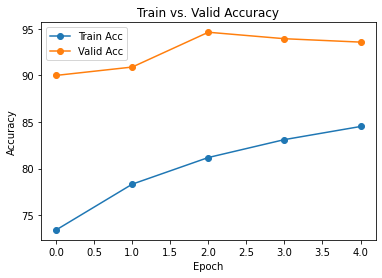

In [22]:
plt.plot(train_acc,'-o')
plt.plot(val_acc,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train Acc','Valid Acc'])
plt.title('Train vs. Valid Accuracy')

plt.show()

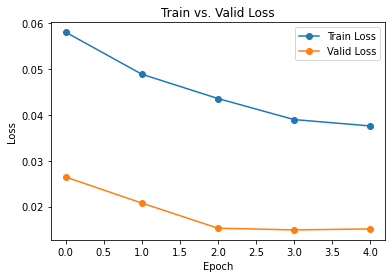

In [23]:
plt.plot(train_loss,'-o')
plt.plot(val_loss,'-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss','Valid Loss'])
plt.title('Train vs. Valid Loss')

plt.show()

In [24]:
torch.save(net.state_dict(), "./model(06-29-22).pth")